In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from statsmodels.tsa.api import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

sns.set_style('darkgrid')

In [2]:
df=pd.read_csv('AirPassengers.csv')
df.index=pd.to_datetime(df['Month'],format='%Y-%m')
df=df.drop('Month',axis=1)
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


<AxesSubplot:xlabel='Month'>

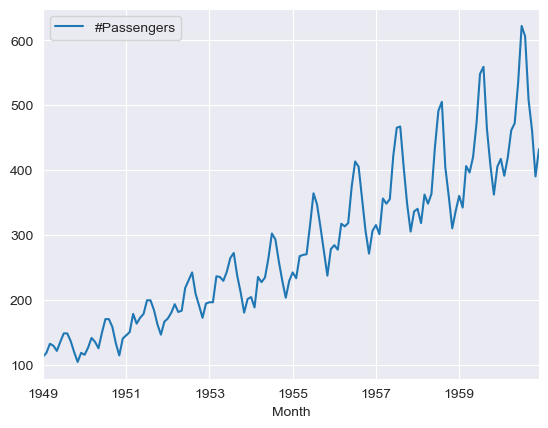

In [3]:
df.plot()

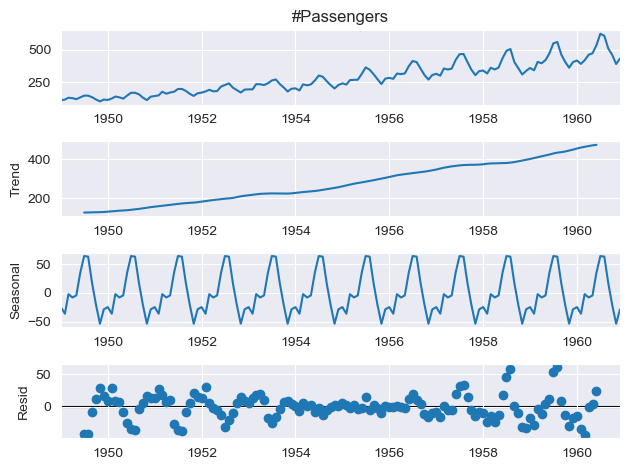

In [4]:
decompose = seasonal_decompose(df['#Passengers']).plot()

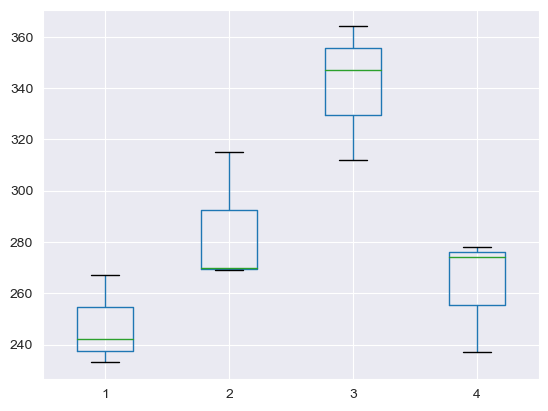

In [5]:
# Data vaikuttaa vaihtelevan säännöllisesti vuodenajan mukaan. 
# Tehdään yhdestä vuodesta boxplot vuosineljännesten perusteella
nel = pd.DataFrame(np.empty((0, 4)))
vuosi = df.loc['1955']
ryh = vuosi.groupby(pd.Grouper(freq='Q'))
nel = pd.concat([pd.DataFrame(x[1].values) for x in ryh], axis=1)
nel = pd.DataFrame(nel)
nel.columns = range(1,5)

nel.boxplot()
plt.show()

Nähdään, että matkustajien määrä kasvaa huomattavasti kolmannessa kvartaalissa, eli kesän ja alkusyksyn aikana.

## Mallin sovitus

In [6]:
# freq = 'MS' == kuukauden ensimmäinen päivä
malli = ExponentialSmoothing(df['#Passengers'], trend='add', seasonal='mul', seasonal_periods=12, freq='MS').fit()

# luodaan myös kvartaalimalli
df1 = df.resample("Q").last()
quart_malli = ExponentialSmoothing(df1['#Passengers'], trend='add', seasonal='mul', seasonal_periods=4, freq='Q').fit()

In [7]:
# lisätään ennuste-kolumni kumpaankin
df['Ennuste'] = malli.fittedvalues
df1['Ennuste'] = quart_malli.fittedvalues

<AxesSubplot:xlabel='Month'>

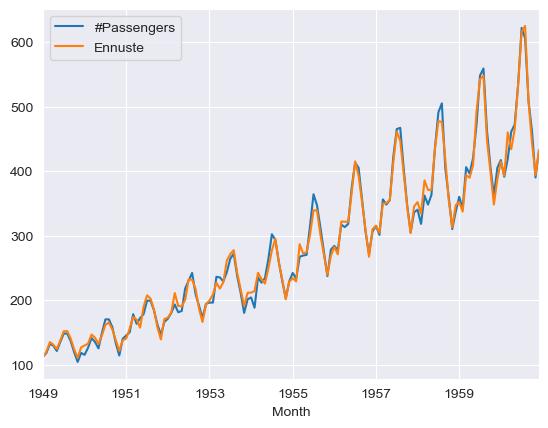

In [8]:
# katsotaan viivakaavioiden avulla, kuinka hyvin ennuste matkii todellisia arvoja
df.plot()

Text(0.5, 0, 'Quarter')

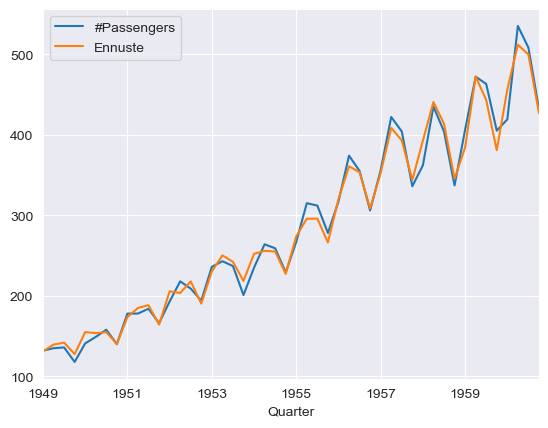

In [9]:
df1.plot()
plt.xlabel('Quarter')

In [10]:
# lisätään ennustevirhe kumpaankin
df['Ennustevirhe'] = malli.resid
df1['Ennustevirhe'] = quart_malli.resid
df

,#Passengers,Ennuste,Ennustevirhe
Month,,,
1949-01-01,112,111.418413,0.581587
1949-02-01,118,120.062977,-2.062977
1949-03-01,132,134.828655,-2.828655
1949-04-01,129,130.593148,-1.593148
1949-05-01,121,124.088708,-3.088708
...,...,...,...
1960-08-01,606,625.005704,-19.005704
1960-09-01,508,506.744517,1.255483
1960-10-01,461,443.213419,17.786581


## Tarkastelu

In [11]:
# Lasketaan mallien virheellisyyden keskiarvo
print('Monthly:')
print('Mean squared error: ', mean_squared_error(df['#Passengers'], df['Ennuste']))
print('Mean absolute error: ', mean_absolute_error(df['#Passengers'], df['Ennuste']))
print()
print('Quarterly:')
print('Mean squared error: ', mean_squared_error(df1['#Passengers'], df1['Ennuste']))
print('Mean absolute error: ', mean_absolute_error(df1['#Passengers'], df1['Ennuste']))

Monthly:
Mean squared error:  110.78392381180136
Mean absolute error:  7.953222055847547

Quarterly:
Mean squared error:  161.30696561946561
Mean absolute error:  9.841485622658103


Keskiarvojen perusteella aikasarjan tutkiminen kuukausien perusteella on tarkempaa kuin kvartaalien kanssa. 

Text(0, 0.5, 'Ennustevirhe')

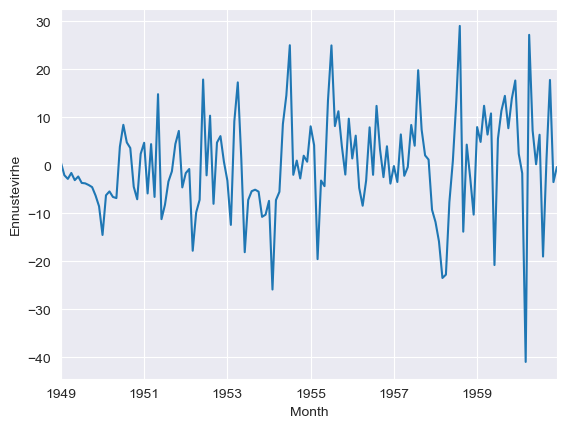

In [12]:
# katsotaan ennustusvirheitä viivakaavioina
df['Ennustevirhe'].plot()
plt.ylabel('Ennustevirhe')

Text(0.5, 0, 'Quarter')

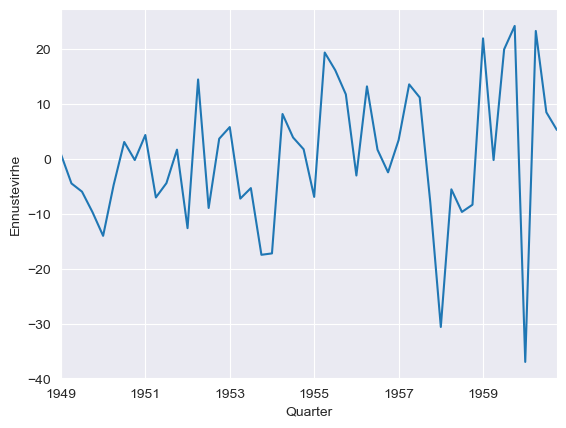

In [13]:
df1['Ennustevirhe'].plot()
plt.ylabel('Ennustevirhe')
plt.xlabel('Quarter')

Text(0.5, 1.0, 'Month')

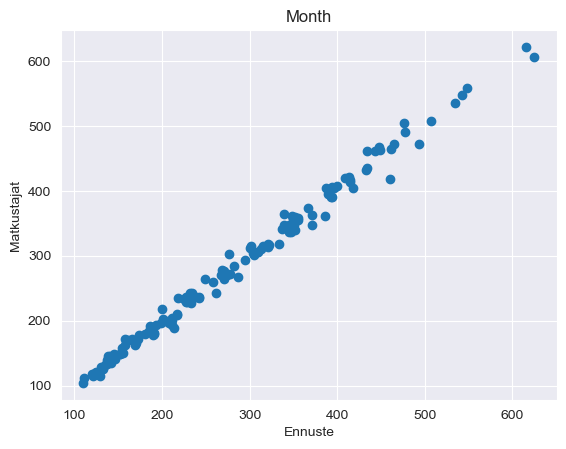

In [14]:
# sitten hajontakaavioina
plt.scatter(x=df['Ennuste'], y=df['#Passengers'])
plt.xlabel('Ennuste')
plt.ylabel('Matkustajat')
plt.title('Month')

Text(0.5, 1.0, 'Quarter')

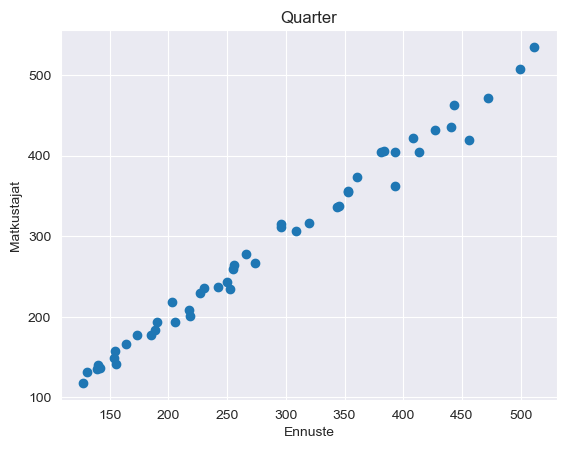

In [15]:
plt.scatter(x=df1['Ennuste'], y=df1['#Passengers'])
plt.xlabel('Ennuste')
plt.ylabel('Matkustajat')
plt.title('Quarter')

Kummassakin hajontakaaviossa ennuste ja todellinen arvo kohtaavat hyvin mallin alkupäässä, mutta puolivälin jälkeen alkavat heittelehtiä, varsinkin kvartaalimallissa. 

## Tulevan ennustus

In [16]:
# ennustetaan aikasarjaa seuraavia arvoja! 
# 1960-12-01 on datasetin viimeinen päivä, ensimmäinen ennustettava päivä on siis 1961-01-01
# freq = 'MS' == kuukauden ensimmäinen päivä
index = pd.date_range('1961-01-01', periods=12, freq='MS')
ennuste = malli.forecast(12)
df_ennuste = pd.DataFrame(data=ennuste, index=index, columns=['Ennuste'])
df_ennuste

,Ennuste
1961-01-01,445.243672
1961-02-01,418.226795
1961-03-01,465.313688
1961-04-01,494.949772
1961-05-01,505.476830
1961-06-01,573.315096
1961-07-01,663.597469
1961-08-01,654.905853
1961-09-01,546.760868
1961-10-01,488.445875


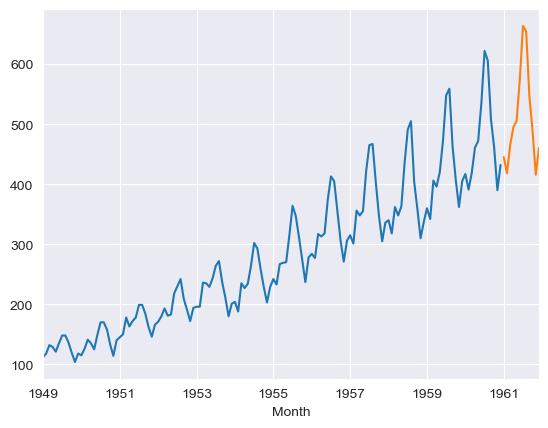

In [17]:
df['#Passengers'].plot()
df_ennuste['Ennuste'].plot()
plt.show()

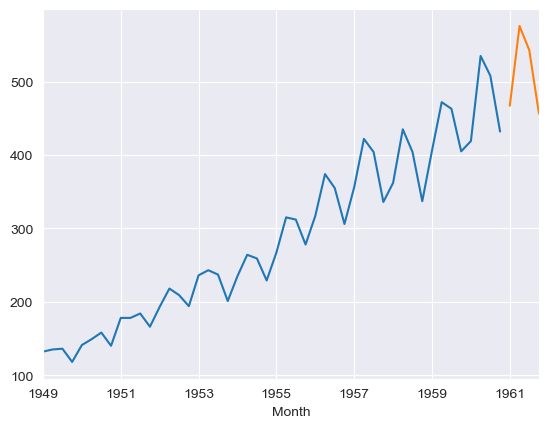

In [18]:
# sitten samat kvartaalimallille
index = pd.date_range('1961-01-01', periods=4, freq='Q')
ennuste1 = quart_malli.forecast(4)
df1_ennuste = pd.DataFrame(data=ennuste1, index=index, columns=['Ennuste'])

df1['#Passengers'].plot()
df1_ennuste['Ennuste'].plot()
plt.show()

In [19]:
df2 = pd.concat([df, df_ennuste])
df2

,#Passengers,Ennuste,Ennustevirhe
1949-01-01,112.0,111.418413,0.581587
1949-02-01,118.0,120.062977,-2.062977
1949-03-01,132.0,134.828655,-2.828655
1949-04-01,129.0,130.593148,-1.593148
1949-05-01,121.0,124.088708,-3.088708
...,...,...,...
1961-08-01,NaN,654.905853,NaN
1961-09-01,NaN,546.760868,NaN
1961-10-01,NaN,488.445875,NaN
1961-11-01,NaN,415.724391,NaN


In [20]:
df3 = pd.concat([df1, df1_ennuste])
df3

,#Passengers,Ennuste,Ennustevirhe
1949-03-31,132.0,131.128693,0.871307
1949-06-30,135.0,139.472197,-4.472197
1949-09-30,136.0,141.973236,-5.973236
1949-12-31,118.0,127.730058,-9.730058
1950-03-31,141.0,155.021094,-14.021094
1950-06-30,149.0,153.734633,-4.734633
1950-09-30,158.0,154.920215,3.079785
1950-12-31,140.0,140.207827,-0.207827
1951-03-31,178.0,173.649195,4.350805
1951-06-30,178.0,185.031495,-7.031495
